# Best fits analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.constants import c as c_light  # units of m/s
c_light_km = c_light / 1000 # units of km/s

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_figures = os.path.join(path_git, 'notebooks', 'figures')

#B1: lcdm biased
#B2: GILA biased

def F_H(H, params, model):     
    lamb, L, beta, L_bar = params
    if model == 'GILA':
        FH = H**2 \
           + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2) \
           - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10)
    
    elif model == 'BETA':
        FH = H**2 \
            + H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4) \
            - H**2        * beta * np.exp(-beta*(L_bar*H)**8) 

    return FH

def F_H_prime(H, params, model):
    lamb, L, beta, L_bar = params

    if model == 'GILA':
        aux = np.exp(lamb*(L*H)**2)       * lamb * (L*H)**6     * (4 + lamb * (L*H)**2) +\
              np.exp(-beta*(L_bar*H)**10) * beta * (L_bar*H)**4 * (-3 + 5 * beta * (L_bar*H)**10)
    
    if model == 'BETA':
        aux = 2 * np.exp(lamb*(L*H)**4)       * lamb * (L*H)**6 * (2 + lamb*(L*H)**4) +\
                  np.exp(-beta*(L_bar*H)**8)  * beta                * (-1 + 4 * beta * (L_bar*H)**8)

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime

def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, model] = params_ode

    F_H0 = F_H(H_0, [lamb, L, b, L_bar], model)

    omega_r_0 = 2.47e-5
    omega_m_0 = F_H0 /(100**2) - omega_r_0

    rho_m_0 = 100**2 * omega_m_0 / kappa
    rho_r_0 = 100**2 * omega_r_0 / kappa
    
    #a = 1/(1+z)

    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [lamb, L, b, L_bar],model))     
    #print(s)
    return s


def integrator(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=10,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, b, H0 = physical_params
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    ode_params = [0, 1e-27/H0, b, L_bar/H0, H0, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final


def E_2(zs, Omega_r, Omega_m, Omega_Lambda):
    return (1+zs)**4 * Omega_r + (1+zs)**3 * Omega_m + Omega_Lambda

In [3]:
#Fixed values
zs = np.linspace(0,10,10**5)
omega_r = 2.47e-5
L_bar = 0.89

#Lcdm best fit
H_0_lcdm = 72.163
omega_m_lcdm = 0.163

#Beta best fit
beta_beta = 0.7
H_0_beta = 70

#GILA best fit
beta_gila = 1.2
H_0_gila = 71

In [4]:
#Lcdm model
Omega_r_lcdm = omega_r/(H_0_lcdm/100)**2
Omega_m_lcdm = omega_m_lcdm / (H_0_lcdm/100)**2
Omega_Lambda_lcdm = 1 - Omega_r_lcdm - Omega_m_lcdm

Omega_r_lcdm_z = Omega_r_lcdm * (1+zs)**4 / E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm)
Omega_m_lcdm_z = Omega_m_lcdm * (1+zs)**3 / E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm)
Omega_Lambda_lcdm_z = Omega_Lambda_lcdm / E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm)

#Beta model
omega_m_beta = F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/(100**2) - omega_r

Omega_r_beta_B1 = omega_r/(H_0_beta/100)**2
Omega_m_beta_B1 = omega_m_beta / (H_0_beta/100)**2
Omega_Lambda_beta_B1 = 1- Omega_r_beta_B1 - Omega_m_beta_B1

Omega_r_beta_B2 = omega_r / (F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/100**2)
Omega_m_beta_B2 = omega_m_beta / (F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/100**2)

physical_params = [L_bar, beta_beta, H_0_beta]
_, Hs_beta = integrator(physical_params, num_z_points=int(1e5), initial_z=0, final_z=10,model='BETA')

Omega_r_beta_B1_z = Omega_r_beta_B1 * (1+zs)**4 / E_2(zs, Omega_r_beta_B1, Omega_m_beta_B1, Omega_Lambda_beta_B1)
Omega_m_beta_B1_z = Omega_m_beta_B1 * (1+zs)**3 / E_2(zs, Omega_r_beta_B1, Omega_m_beta_B1, Omega_Lambda_beta_B1)
Omega_Lambda_beta_B1_z = Omega_Lambda_beta_B1 / E_2(zs, Omega_r_beta_B1, Omega_m_beta_B1, Omega_Lambda_beta_B1)
Omega_r_beta_B2_z = Omega_r_beta_B2 * (1+zs)**4 / (F_H(Hs_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA'))
Omega_m_beta_B2_z = Omega_m_beta_B2 * (1+zs)**3 / (F_H(Hs_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA'))

#GILA model
omega_m_gila = F_H(H_0_gila, [0, 1, beta_gila, L_bar/H_0_gila], 'GILA')/(100**2) - omega_r

Omega_r_gila_B1 = omega_r/(H_0_gila/100)**2
Omega_m_gila_B1 = omega_m_gila / (H_0_gila/100)**2
Omega_Lambda_gila_B1 = 1- Omega_r_gila_B1 - Omega_m_gila_B1

Omega_r_gila_B2 = omega_r / (F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila], 'GILA')/100**2)
Omega_m_gila_B2 = omega_m_gila / (F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila], 'GILA')/100**2)

physical_params = [L_bar, beta_gila, H_0_gila]
_, Hs_gila = integrator(physical_params, num_z_points=int(1e5), initial_z=0, final_z=10,model='GILA')

Omega_r_gila_B1_z = Omega_r_gila_B1 * (1+zs)**4 / E_2(zs, Omega_r_gila_B1, Omega_m_gila_B1, Omega_Lambda_gila_B1)
Omega_m_gila_B1_z = Omega_m_gila_B1 * (1+zs)**3 / E_2(zs, Omega_r_gila_B1, Omega_m_gila_B1, Omega_Lambda_gila_B1)
Omega_Lambda_gila_B1_z = Omega_Lambda_gila_B1   / E_2(zs, Omega_r_gila_B1, Omega_m_gila_B1, Omega_Lambda_gila_B1)
Omega_r_gila_B2_z = Omega_r_gila_B2 * (1+zs)**4 / (F_H(Hs_gila, [0, 0, beta_gila, L_bar/H_0_gila], 'GILA')/F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila], 'GILA'))
Omega_m_gila_B2_z = Omega_m_gila_B2 * (1+zs)**3 / (F_H(Hs_gila, [0, 0, beta_gila, L_bar/H_0_gila], 'GILA')/F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila], 'GILA'))

print('LCDM: {}'.format(Omega_r_lcdm + Omega_m_lcdm + Omega_Lambda_lcdm))
print('BETA_B1: {}'.format(Omega_r_beta_B1 + Omega_m_beta_B1 + Omega_Lambda_beta_B1))
print('GILA_B1: {}'.format(Omega_r_gila_B1 + Omega_m_gila_B1 + Omega_Lambda_gila_B1))
print('BETA_B2: {}'.format(Omega_r_beta_B2 + Omega_m_beta_B2))
print('GILA_B2: {}'.format(Omega_r_gila_B2 + Omega_m_gila_B2))

print(Omega_m_beta_B1, Omega_m_gila_B1)
print(Omega_r_beta_B2, Omega_m_gila_B2)

LCDM: 0.9999999999999999
BETA_B1: 1.0
GILA_B1: 0.9999999999999999
BETA_B2: 1.0
GILA_B2: 1.0
0.46854742089402496 0.48206200281598105
0.00010757233631815073 0.999898367358274


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


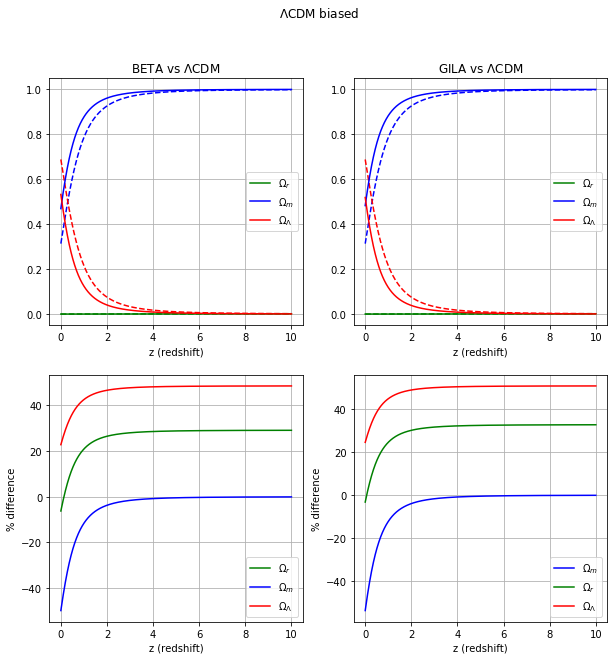

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle(r'$\rm{\Lambda CDM}$ biased')

ax[0,0].set_title(r'BETA vs $\rm{\Lambda CDM}$')
ax[0,0].grid()
ax[0,0].plot(zs, Omega_r_lcdm_z, 'g--')
ax[0,0].plot(zs, Omega_m_lcdm_z, 'b--')
ax[0,0].plot(zs, Omega_Lambda_lcdm_z, 'r--')
ax[0,0].plot(zs, Omega_r_beta_B1_z, 'g', label=r'$\Omega_r$')
ax[0,0].plot(zs, Omega_m_beta_B1_z, 'b', label=r'$\Omega_m$')
ax[0,0].plot(zs, Omega_Lambda_beta_B1_z, 'r', label=r'$\Omega_{{\Lambda}}$')
ax[0,0].set_xlabel('z (redshift)')
ax[0,0].legend()

ax[0,1].set_title(r'GILA vs $\rm{\Lambda CDM}$')
ax[0,1].grid()
ax[0,1].plot(zs, Omega_r_lcdm_z, 'g--')
ax[0,1].plot(zs, Omega_m_lcdm_z, 'b--')
ax[0,1].plot(zs, Omega_Lambda_lcdm_z, 'r--')
ax[0,1].plot(zs, Omega_r_gila_B1_z, 'g', label=r'$\Omega_r$')
ax[0,1].plot(zs, Omega_m_gila_B1_z, 'b', label=r'$\Omega_m$')
ax[0,1].plot(zs, Omega_Lambda_gila_B1_z, 'r', label=r'$\Omega_{{\Lambda}}$')
ax[0,1].set_xlabel('z (redshift)')
ax[0,1].legend()

ax[1,0].grid()
ax[1,0].plot(zs, 100*(1-Omega_r_beta_B1_z/Omega_r_lcdm_z), 'g', label=r'$\Omega_r$')
ax[1,0].plot(zs, 100*(1-Omega_m_beta_B1_z/Omega_m_lcdm_z), 'b',label=r'$\Omega_m$')
ax[1,0].plot(zs, 100*(1-Omega_Lambda_beta_B1_z/Omega_Lambda_lcdm_z), 'r', label=r'$\Omega_{{\Lambda}}$')
ax[1,0].set_ylabel('% difference')
ax[1,0].set_xlabel('z (redshift)')
ax[1,0].legend()

ax[1,1].grid()
ax[1,1].plot(zs, 100*(1-Omega_m_gila_B1_z/Omega_m_lcdm_z), 'b',label=r'$\Omega_m$')
ax[1,1].plot(zs, 100*(1-Omega_r_gila_B1_z/Omega_r_lcdm_z), 'g', label=r'$\Omega_r$')
ax[1,1].plot(zs, 100*(1-Omega_Lambda_gila_B1_z/Omega_Lambda_lcdm_z), 'r', label=r'$\Omega_{{\Lambda}}$')
ax[1,1].set_ylabel('% difference')
ax[1,1].set_xlabel('z (redshift)')
ax[1,1].legend()

os.chdir(path_figures)
fig.savefig('Omegas_LCDM_biased_{}.pdf'.format(L_bar))

/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


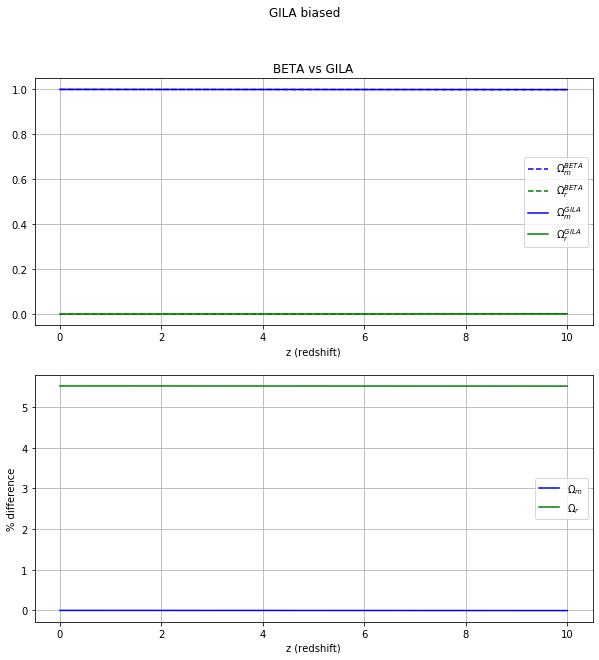

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
fig.suptitle(r'GILA biased')
ax[0].set_title(r'BETA vs GILA')
ax[0].grid()
ax[0].plot(zs, Omega_m_beta_B2_z, '--b', label=r'$\Omega_m^{BETA}$')
ax[0].plot(zs, Omega_r_beta_B2_z, '--g', label=r'$\Omega_r^{BETA}$')
ax[0].plot(zs, Omega_m_gila_B2_z, 'b', label=r'$\Omega_m^{GILA}$')
ax[0].plot(zs, Omega_r_gila_B2_z, 'g', label=r'$\Omega_r^{GILA}$')
ax[0].set_xlabel('z (redshift)')
ax[0].legend()

ax[1].grid()
ax[1].plot(zs, 100*(1-Omega_m_gila_B2_z/Omega_m_beta_B2_z), 'b',label=r'$\Omega_m$')
ax[1].plot(zs, 100*(1-Omega_r_gila_B2_z/Omega_r_beta_B2_z), 'g', label=r'$\Omega_r$')
ax[1].set_ylabel('% difference')
ax[1].set_xlabel('z (redshift)')
ax[1].legend()

os.chdir(path_figures)
fig.savefig('Omegas_GILA_biased_{}.pdf'.format(L_bar))


El tema es el siguiente

$\Omega_m^{B2}(z=0) \neq \Omega_{m,0}^{B2} $ ya que si $\beta>0$, entonces $H_0^2 > F(H_0)$. Esto tiene implicancias en las definiciones de Omega_r_gila_B2_z y Omega_m_gila_B2_z

/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


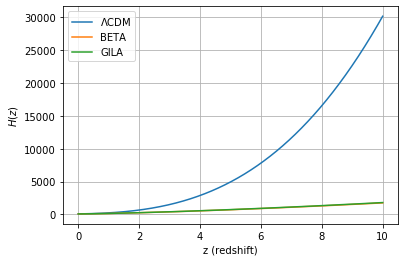

In [7]:
plt.grid()
plt.plot(zs, H_0_lcdm * E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm))
plt.plot(zs, Hs_beta)
plt.plot(zs, Hs_gila)
#plt.xlim(0,3)
plt.xlabel('z (redshift)')
plt.ylabel(r'$H(z)$')
plt.legend([r'$\rm{\Lambda CDM}$', r'BETA', r'GILA'])
plt.show()
